# Assignment 3
## Name: Thi Tuyet Nhi Nguyen
## Student ID: 202398785

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
def find_element(arr, tar):
    try:
        for i, row in enumerate(arr):
            if tar in row:
                return (i, row.index(tar))
    except ValueError:
        raise ValueError("Value not found!") 
    

class GridWorld:

    def __init__(self):
        # set up parameters
        self.n_row = 5
        self.n_col = 5
        self.n_state = self.n_row * self.n_col
        self.n_action = 4

        # Available actions
        #                      left      down      right     up
        self.action =       [ [0, -1],  [1, 0],   [0, 1],   [-1, 0]]
        self.action_text =  ['\u2190', '\u2193', '\u2192', '\u2191']  # unicode text used for visualization

        # Gridworld map
        #             0   1   2   3   4
        self.map = [['T','W','W','W','T'], # 0          map[0][4] = 'T'
                    ['W','W','W','W','W'], # 1
                    ['R','R','W','R','R'], # 2          map[2][3] = 'R'
                    ['W','W','W','W','W'], # 3
                    ['B','W','W','W','W']] # 4          map[4][0] = 'B'

        # Define the initial state "B"
        row_0, col_0 = find_element(self.map, 'B')
        self.state_0 = row_0 * self.n_row + col_0  # calculate the state number based on the place on the map

        self.model = [[[] for _ in range(self.n_action)] for _ in range(self.n_state)]
        for s in range(self.n_state):
            for a in range(self.n_action):
                row, col = np.divmod(s,self.n_row)  # calculate the place on the map based on the state number
                act = self.action[a]  # 0 left, 1 down, 2 right, 3 up
                row_, col_ = row + act[0], col + act[1]  # new positions after action
                state_ = row_ * self.n_row + col_  # calculate the state number based on the place on the map
                outsidecheck = (row_ < 0) or (col_ < 0) or (row_ > self.n_row - 1) or (col_ > self.n_col - 1)  # whether the new position is outside the grid

                # Blue
                if self.map[row][col] == 'B':
                    if outsidecheck:
                        self.model[s][a].append([1.0, s, -1.0, False])  # if want to move out, stay and -1.0
                    else:
                        self.model[s][a].append([1.0, state_, -1.0, False])

                # White
                elif self.map[row][col] == 'W':
                    if outsidecheck:
                        self.model[s][a].append([1.0, s, -1.0, False])  # if want to move out, stay and -1.0
                    elif self.map[row_][col_] == 'R':  # if move to R, jump to start point
                        self.model[s][a].append([1.0, self.state_0, -20.0, False])
                    elif self.map[row_][col_] == 'T':  # if move to terminal state, end
                        self.model[s][a].append([1.0, state_, -1.0, True])
                    else:
                        self.model[s][a].append([1.0, state_, -1.0, False])

                # Red
                elif self.map[row][col] == 'R':  # if current is red, just for indexing
                    self.model[s][a].append([1.0, s, 0.0, False])
                    
                # Black (Terminal)
                elif self.map[row][col] == 'T':  # if current is terminal, just for indexing
                    self.model[s][a].append([1.0, s, 0.0, True])
                
                else:
                    raise ValueError("Unknown value!")

In [3]:
def argmax_random(input_array): 
    return np.random.choice(np.flatnonzero(input_array == np.max(input_array)))


def select_action(q, eps, env):
    if np.random.rand() > eps:  # ϵ-greedy
        return argmax_random(q)  # randomely select the largest action
    else:
        return np.random.choice([i for i in range(env.n_action)])  # randomely select


def find_policy(gamma, V, env):
    pol = [[0] for _ in range(env.n_state)]  # initialize a deterministic policy

    for s in range(env.n_state):  # sweep all the states in the state space
        temp1 = []
        for a in range(env.n_action):  
            temp2 = 0
            for p, s_, r, _ in env.model[s][a]:  
                temp2 += p * (r + gamma * V[s_])
            temp1.append(temp2)
                
        pol[s] = (np.unique(np.argwhere(temp1 == np.max(temp1)))).tolist()  
        
    return pol


def print_policy(policy, env):
    policy_visual = ['' for _ in range(env.n_state)]

    for s in range(env.n_state):
        lenth = len(policy[s])
        if lenth == 4:  
            policy_visual[s] += 'o'  # 'o' means 4 directions are all available
        else:
            for a in range(lenth):
                policy_visual[s] += env.action_text[policy[s][a]]  

    return policy_visual


def plot_trajectory(policy, env):
    trajectory_visual = [' ' for _ in range(env.n_state)]
    s = env.state_0
    for _ in range(100):  
        trajectory_visual[s] = env.action_text[policy[s][0]]  
        _, s_, _, t = env.model[s][policy[s][0]][0]  
        s = s_

        if t:  # if next state is the terminal state
            trajectory_visual[s] = 'x'
            break

    return trajectory_visual

In [4]:
def Sarsa(max_ep, gamma, epsilon, alpha, env):
    # Initialize
    policy_opt = [[0] for _ in range(env.n_state)]  
    Q_all = [[0 for _ in range(env.n_action)] for _ in range(env.n_state)]  
    Q_opt = [0 for _ in range(env.n_state)]
    reward_trace = [0 for _ in range(max_ep)]

    # for each episode
    for ep in range(max_ep):
        # initialize
        s = env.state_0
        a = select_action(Q_all[s], epsilon, env)
        r_sum = 0

        while 1:
            _, s_, r, t = env.model[s][a][0]  # get new state and reward
            a_ = select_action(Q_all[s_], epsilon, env)  
            Q_all[s][a] += alpha * (r + gamma * Q_all[s_][a_] - Q_all[s][a])  
            s, a = s_, a_  # update state and action
            r_sum += r  # update reward sum
            if t:  # if next state is the terminal state
                break

        reward_trace[ep] = r_sum  # record reward sum

    for s in range(env.n_state):  
        policy_opt[s] = (np.unique(np.argwhere(Q_all[s] == np.max(Q_all[s])))).tolist() 

    Q_opt = np.max(Q_all, axis=1)  # find the optimal Q function

    return Q_all, Q_opt, policy_opt, reward_trace

In [5]:
def Q_learning(max_ep, gamma, epsilon, alpha, env):
    # Initialize
    policy_opt = [[0] for _ in range(env.n_state)] 
    Q_all = [[0 for _ in range(env.n_action)] for _ in range(env.n_state)] 
    Q_opt = [0 for _ in range(env.n_state)]
    reward_trace = [0 for _ in range(max_ep)]

    # for each episode
    for ep in range(max_ep):
        # initialize
        s = env.state_0
        r_sum = 0

        while 1:
            a = select_action(Q_all[s], epsilon, env)  
            _, s_, r, t = env.model[s][a][0]  # get new state and reward
            Q_max = np.max(Q_all[s_])  # find the maximum q value
            Q_all[s][a] += alpha * (r + gamma * Q_max - Q_all[s][a])  
            s = s_  
            r_sum += r  
            if t:  
                break
        
        reward_trace[ep] = r_sum  # record reward sum

    for s in range(env.n_state): 
        policy_opt[s] = (np.unique(np.argwhere(Q_all[s] == np.max(Q_all[s])))).tolist()  

    Q_opt = np.max(Q_all, axis=1)

    return Q_all, Q_opt, policy_opt, reward_trace

In [6]:
# Initialize the environment, set up parameters
max_ep = 10000
gam = 0.99  # discount factor
eps = 0.2  # epsilon, Algorithm parameter: small ϵ > 0
alp = 0.5  # learning rate
Env = GridWorld()

# Find the optimal policy
Q_1, Q_opt_1, pol_opt_1, reward_plot_1 = Sarsa(max_ep, gam, eps, alp, Env)
Q_2, Q_opt_2, pol_opt_2, reward_plot_2 = Q_learning(max_ep, gam, eps, alp, Env)

Sarsa algorithm:
[['o' '←' '←' '→' 'o']
 ['↑' '→' '↑' '↑' '↑']
 ['o' 'o' '↑' 'o' 'o']
 ['↓' '→' '↑' '←' '←']
 ['→' '↑' '↓' '←' '←']] 

Q-learning algorithm:
[['o' '←' '←→' '→' 'o']
 ['↑' '←↑' '←→↑' '→↑' '↑']
 ['o' 'o' '↑' 'o' 'o']
 ['→' '→' '↑' '←' '←']
 ['→↑' '→↑' '↑' '←↑' '↑']] 

Sarsa algorithm trajectory:
[['x' '←' '←' ' ' ' ']
 [' ' ' ' '↑' ' ' ' ']
 [' ' ' ' '↑' ' ' ' ']
 [' ' '→' '↑' ' ' ' ']
 ['→' '↑' ' ' ' ' ' ']] 

Q-learning algorithm trajectory:
[['x' ' ' ' ' ' ' ' ']
 ['↑' '←' '←' ' ' ' ']
 [' ' ' ' '↑' ' ' ' ']
 [' ' ' ' '↑' ' ' ' ']
 ['→' '→' '↑' ' ' ' ']] 



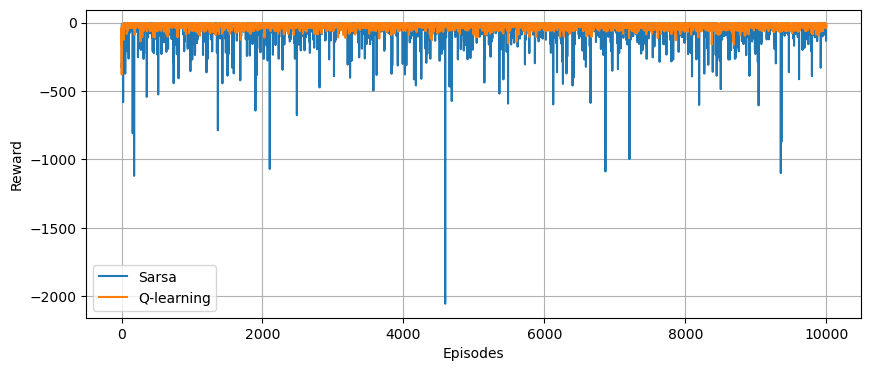

In [ ]:
# Print the results
print('Sarsa algorithm:')
print((np.array(print_policy(pol_opt_1, Env))).reshape([5, -1]), '\n')

print('Q-learning algorithm:')
print((np.array(print_policy(pol_opt_2, Env))).reshape([5, -1]), '\n')

print('Sarsa algorithm trajectory:')
print((np.array(plot_trajectory(pol_opt_1, Env))).reshape([5, -1]), '\n')

print('Q-learning algorithm trajectory:')
print((np.array(plot_trajectory(pol_opt_2, Env))).reshape([5, -1]), '\n')

fig1 = plt.figure(figsize=(10, 4))
plt.plot(range(1,max_ep+1), reward_plot_1, label = "Sarsa")
plt.plot(range(1,max_ep+1), reward_plot_2, label = "Q-learning")
plt.xlabel('Episodes')
plt.ylabel('Reward')
plt.legend(loc='lower left')
plt.grid()
plt.show()

In [11]:
print('Sarsa algorithm:')
print(np.array(Q_1), '\n')

Sarsa algorithm:
[[  0.           0.           0.           0.        ]
 [ -1.          -9.04663618  -6.08905448  -3.69216636]
 [ -2.47258096  -6.29730435  -4.41985282  -5.40558571]
 [ -4.58798687  -3.56847303  -1.          -1.99876758]
 [  0.           0.           0.           0.        ]
 [ -7.33124075 -40.97026579  -7.28795382  -1.        ]
 [ -5.65305618 -36.31100936  -4.26066078  -6.6897283 ]
 [-14.57538656 -11.47606316  -6.38392534  -3.58985144]
 [ -8.06568739 -48.86830092 -13.77279172  -2.02163703]
 [-14.60664255 -42.09711805  -2.02484983  -1.        ]
 [  0.           0.           0.           0.        ]
 [  0.           0.           0.           0.        ]
 [-39.49826692 -16.96930797 -36.1350812  -14.48019802]
 [  0.           0.           0.           0.        ]
 [  0.           0.           0.           0.        ]
 [-25.76331774 -23.03233308 -38.23135044 -43.69627818]
 [-29.15816088 -22.03845029 -14.4634479  -38.59495892]
 [-26.69647788 -23.92635584 -24.46205163  -7.549

In [12]:
print('Q-learning algorithm:')
print(np.array(Q_2), '\n')

Q-learning algorithm:
[[  0.           0.           0.           0.        ]
 [ -1.          -2.9701      -2.9701      -1.99      ]
 [ -1.99        -3.940399    -1.99        -2.9701    ]
 [ -2.9701      -2.9701      -1.          -1.99      ]
 [  0.           0.           0.           0.        ]
 [ -1.99       -27.64827525  -2.9701      -1.        ]
 [ -1.99       -27.64827525  -3.940399    -1.99      ]
 [ -2.9701      -4.90099501  -2.9701      -2.9701    ]
 [ -3.940399   -27.64827525  -1.99        -1.99      ]
 [ -2.9701     -27.64827525  -1.99        -1.        ]
 [  0.           0.           0.           0.        ]
 [  0.           0.           0.           0.        ]
 [-27.64827525  -5.85198506 -27.64827525  -3.940399  ]
 [  0.           0.           0.           0.        ]
 [  0.           0.           0.           0.        ]
 [ -7.72553056  -8.64827525  -6.79346521 -27.64827525]
 [ -7.72553056  -7.72553056  -5.85198506 -27.64827525]
 [ -6.79346521  -6.79346521  -6.79346521  -